# Basic regression: Predict fuel efficiency

This project will focus on basic regression, where we will predict the fuel efficiency of a car based on a provided dataset. 


- Regression problems look to predict the output of a continuous value, such as probability or price.

<br>

In this project we will use the well known Auto MPG (miles per gallon) dataset. This dataset includes car models from the late 1970s to the early 1980s.

The dimensions, or column headings if we are thinkng tabular, are cylinder count, origin, displacement (engine size), horsepower and weight of the vehicle. 

<br>

---

<br>

While there are many ways to deploy a regression problem, in this project we will use **Keras**, as it is extremely fast and easy. 

We will begin by installing seaborn, a very useful python visualization library. I recommend setting up your installs seperate to other dependencies, as these take more time, and slow down updating your import dependencies.

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

### Download the Data

We will now doanload the data from the University of California, Irvine webise, and then use pandas to import the data.

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

We can now take a look at our data. we can use the `.head()` or `.tail()` command.

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

We can check to see if there are any missing values in the data with the `.isna` function, where we will get an output of all the dimensions and the sum of missing values.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

There are several ways to deal with misssing data, including using averagess, SME input, dropping, etc. And in this case we will be dropping the 6 entries that are misssing horsepower to keep things simple. 

We will do this with the `.dropna()` function

In [7]:
dataset = dataset.dropna()

The `Origin` dimension is categorical, not numeric, meaning that these values are not continuous, and in this case it is country name. 

We can use one-hot-encoding with the `pd.get_dummies` command. One-hot-encoding is one of the easiest ways to transform categorical data to a numeric value, but it will increasse dimensionality of the data set by the number of unique values found in that column. 

In this case, Origin goes from one column, to three (Europe, Japan, USA).

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

Another downside of one-hot-encoding this way is that you need to know all the unique values in that column so that you can create the mapping command, as seen above.

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into training and test sets

As always, we need to split the data into training and testing datasets for the model to run.

We will do this by calling the `.sample` command and seeting our `frac` to `0.8` or 80%. As always, this value can be modified if needed.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

When looking at novel data it is important to see how the different dimensions relate to each other. One of the best ways to do this is with a `.pairplot` where we can see the relationship between each of the vairables or dimensions.

We can read a `.pairplot` by looking at the dimension being evaluated at the top and the bottom of the column or row in question. 

The top row shpws the relationship of MPG against all other vairables included. 

What we see here is that MPG is a component of the other variables, and others tend to be paired off. For example, 'Displacement' and 'Weight' are closely related, which makes sense, as an engine goes up in size, it should generally be heavier as well.

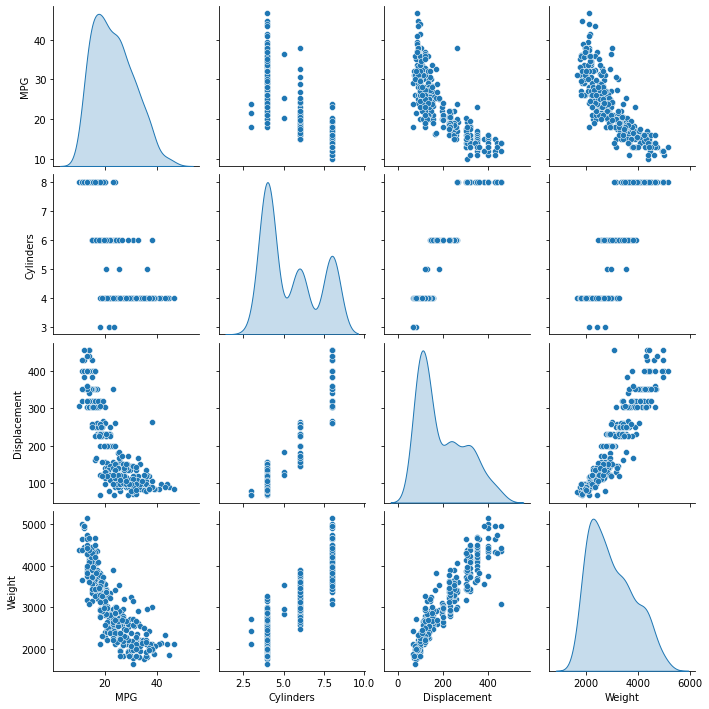

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

We can now ue one of my favourite data exploration command, `.describe`. 

`.describe` gives us all the key stats about our data, so that we can better understand the parameters and patterns of our data. 

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

We have created our seperate training and testing datasets, but we need to remove the label or our target value, aka 

The thing we want to predict

In our case, we want to predict the MPG, but conversely we could lso try to predict another dimension, such as displacement. 

In the following code we will create a copy of our two datasets, and then us `.pop` to remove the column or dimension by name.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

We will use the `.describe` command and the specific columns we want to analyze. In this case we will look at the mean and standard deviation to see how much these value differ, both within the dimension and between dimensions.

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


Looking at the above table, it is very easy to see that these values have massive differences in both mean and std. It is always good practice to normalize your model's features, and it is even more important when you have data this different.

This is because this model will apply weights to each feature, and something like the `Weight` will be affected significantly more than `Cylinders`.


Although a model *might* converge without feature normalization, normalization makes training much more stable.

<br>

---


***Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity.***

### The Normalization layer

We will use the standard layer `tf.keras.layers.Normalization` to normalize the data. 

<br>



---

<br>

First we need to create the `tf.keras.layers.Normalization` layer:



In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Now that we have created this layer, we will now apply this to our data through the `Normalization.adapt` command. This will create an index between the new values and the original.

In [16]:
normalizer.adapt(np.array(train_features))

We will now calculate the mean and variance, and store them in the layer

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


We can see in the following code that the layer will call in the original data and output the new normalized data.

In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression a Tale of Two Regressions

When we complete a linear regression problem, we need to decide if we will be using a single variable for prediction (Weight to predict MPG) or a combination of variables for our prediction. 

### Single-Variable Linear Regression

We will start with a single-variable regression model, and we will use `Horsepower` to help us predict `MPG`.

As with our projects using TensorFlow, we need to define the model architecture, and we do thiss with the `tf.keras.sequential` model. This creates a simple neural network for our model. 

<br>

**A Sequential model is not appropriate for:**

- A plain stack of layers where each layer has exactly one input tensor and one output tensor.

<br>

**A Sequential model is not appropriate when:**

- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a multi-branch model)

<br>


---

There are two key steps in our single-variable linear regresison model:

- Normalize: Using `tf.keras.layers.Normalization`
- Linear Transformation: Using `tf.kerass.layers.Dense`

Note: We must apply our old grade 9 math equation y=mx+b to produce the single output we desire.

Furthermore, we will use the `input.shape` argument to pass in our value of "1". Conversely, we could run the model and have it populate automatically from our input.

Our first step is to create a NumPy array using `Horsepower` and then normalize the array with the `tf.keras.layers.Normalization` command. And as alwayss, we will use the `.adapt` command to connect it to the data.

In [19]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

We can now build the sequential model with the `tf.keras.Sequential` command.

In [20]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Now that the model is built, we need to configure the training procedures using the `Model.compile` command. 

To do this we need to call out the `optimizer` and the `loss` function.

- **Optimizer**: `tf.keras.optimizers.Adam`
- **Loss**: `mean_absolute_error`

In [21]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

We will use the `Model.fit` to train our model. 

<br>

We will pass through our training features and leabels, as well as the number of epochs we want our model to train on. In this case we are going to complete 100 epochs before we finsih.

<br>

We will also supress logging with the `verbose=0`, and make our validation dataset equal to 20% of the total training data.

<br>



---
Note: We will store our training results in the object called `history` for future review.

In [22]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.79 s, sys: 176 ms, total: 4.97 s
Wall time: 7.95 s


We can create a dataframe from the data we just collected on our model's performance with pandas as follows:

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804074,4.176603,95
96,3.804156,4.182815,96
97,3.802620,4.204236,97
98,3.805398,4.199717,98
99,3.802412,4.189550,99


Tables are great, but plotting these values and putting them in a graph is fun, imformative and cool!

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

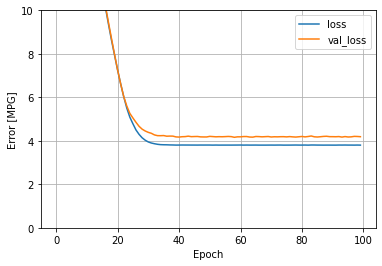

In [25]:
plot_loss(history)

We can see above our mediocre results, and the model seemed to plateau around 30 epochs. 

<br>


---

<br>

We will collect our results for future use with the following code.

In [26]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since we made a single-variable linear regression model, it is very easy for us to both plot and understand our model's predictions based on the `Horsepower` input.

In [27]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [28]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

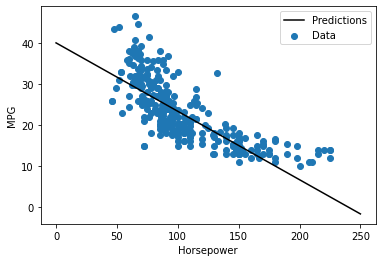

In [29]:
plot_horsepower(x, y)

We can ssee here that the model isn't terrible, and will give you somewhat of an idea of the MPG, but it is not overly accurate. 

We can tell this easily by looking at the above graph: 

1. The data forms more of a crescent than a straight line. 
2. The higher level `Horsepower` values would have unrealistic MPG (less than 1).



In conclusion, this model looks to do best around the 140-150 horsepower as inputs, but this is by far a strong working model.

<br>

---

<br>

We will now try using multiple inputs for informing our model's predictions.

### Multi-Variable Linear Regression

We can use almost the ssame process as before, except we will use a slightly different first layer.

Our first layer will be a `normalizer` layer (`tf.keras.layers.Normalization(axis=-1)`) with the added section to help us deal with having multiple variables.

In [30]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When we use the `Model.predict` command on our batch of inputs, we will get `units=1` outputs for the example below:

In [31]:
linear_model.predict(train_features[:10])

array([[-0.11 ],
       [ 0.343],
       [-0.5  ],
       [-0.571],
       [ 1.432],
       [ 0.011],
       [ 1.54 ],
       [ 0.767],
       [ 0.096],
       [ 2.089]], dtype=float32)

When we call the model, its weight matrices will be built, where before we had an array.

Note: check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [32]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.39 ],
       [-0.031],
       [-0.066],
       [ 0.295],
       [ 0.542],
       [-0.237],
       [ 0.058],
       [ 0.768],
       [ 0.338]], dtype=float32)>

We will now configure the model with Keras `Model.compile`.

In [33]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Now that we have configured the model, we can finally train the model with `Model.fit` for `100` epochs:

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.82 s, sys: 172 ms, total: 4.99 s
Wall time: 10.9 s


This model uses all of the available dimensions, and because of this, we can see a much lower training and validation error from the previous model.

We will plot the results as we did previously:

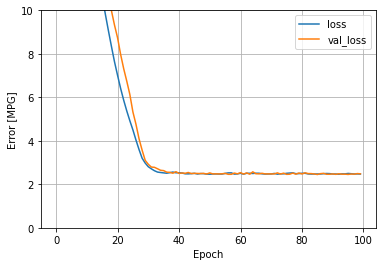

In [35]:
plot_loss(history)

We will now save the ressults for comparisson later:

In [36]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous two examaples we created two linear models, using the basic sequential model, meaning a single input to output relationship of the neural network model. 

In the following two sections we will complete the same process, but with a Deep Neural Network, basically we will have hidden non-linear layers in our model. 

These models should perform better than the linear models based on how we saw the crescent shape of the data dispersement. 

While these models are similar, we will be adding a few new layers in to perform the new non-linear calculations.

Our models will have the following layers:

- Normalization: Same as before 
- Hidden Layerss: We will add in two hidden mon-linear layers. Thee will be `Dense` with the `Relu` activation function (non-linear)
- Linear Dense: A final linear `Dense` layer will be added to create our single output.



---



Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [37]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

We can eassily create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [38]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

DNNs have a few more trainable parameters over the linear models. 

We can use the `.summary()` to see more information about our model.

In [39]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


As previously, we can train the model with Keras by using `Model.fit`:

In [40]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.79 s, sys: 197 ms, total: 3.99 s
Wall time: 3.62 s


Our single input DNN model does perform slightly better than our original `horsepower_model`. We can see the performance of our model below:

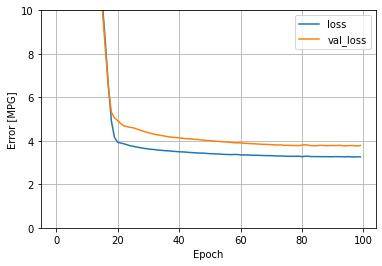

In [41]:
plot_loss(history)

This is great, but lets see how this model maps to the data compared to our prevous linear model:

In [42]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

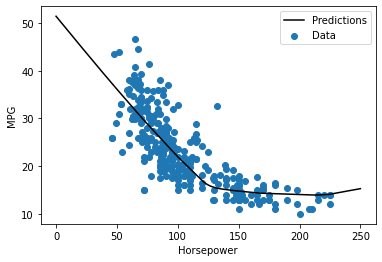

In [43]:
plot_horsepower(x, y)

We can see how this model takes advantage of its non-linear functionality.

<br>

---

We will record the results for later:

In [55]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

We will now repeat the previous steps, except this time we will use all the dimensions. 

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [46]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.9 s, sys: 226 ms, total: 4.12 s
Wall time: 3.75 s


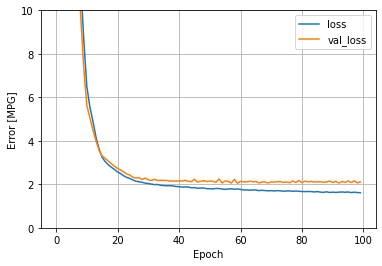

In [47]:
plot_loss(history)

Once again, we see slightly better results with this model. This make sense logically since we know that the DNN model doess better than the non-linear models, and using all the inputs perform better than a ssingle input.

<br>

---

We will now collect our final test results:

In [48]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Congratulations! We have now trained 4 different models on the same data, all completing some form of regression analyssis on it. 

Now that we have completed all the models, we can review all of the results:

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651371
linear_model,2.503957
dnn_horsepower_model,2.931913
dnn_model,1.648784


Our resultss are aligned with our validation error observed during our four model trainings.

### Make predictions

We can now use our models to make predictions. Given that the `dnn_model` performed the best, we will use `Model.predict` on our test data.

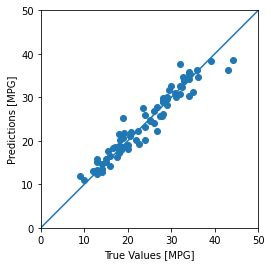

In [50]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like our model did pretty well. It does appear to struggle with outliers, which is common with regression modelss.

---

We will now check the error distribution:

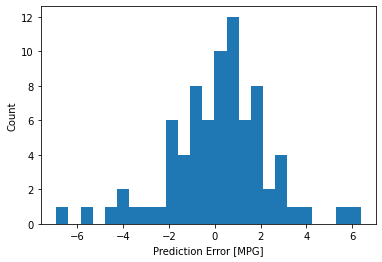

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Our error distribution appears to be aligned with our previous thoughts. 

Let us asssume that this model is exactly how we want it. We need to save the file for future use.

<br>

We can do this with `Model.save`:

In [52]:
dnn_model.save('dnn_model')

We can try reloading the model, and check our results to see if it performs as it should:

In [53]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651371
linear_model,2.503957
dnn_horsepower_model,2.931913
dnn_model,1.648784
reloaded,1.648784


And as expected, our models, `dnn_model` and `reloaded`, have the ssame performance outputs.

## Conclusion

Regression models are a fantastic and fast way to look at how the data reacts to analysis. Furthermore, a regression model is often the fastest way to get a result that is not only acceptable, but often ideal.

Try applying some of the techniques found in this project on your own data and see if you can make predictions. 